# Co-purchasing Analysis based on User Behavior

In [7]:
import re
import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

# Basic environment variables

In [8]:
DATA_PATH = '../../data//amazon-meta.txt'

# Get meta data

In [9]:
def parse_data(limit_line=None):
    f = open(DATA_PATH, 'r', encoding="utf8")
    product_data = {
        'asin':'', 
        'available': 0,
        'title': '',
        'product_group': '',
        'salesrank': 0,
        'similar_items': '',
        'categories_items': '',
        'reviews_num': 0,
        'reviews_avg': 0,
        'reviews_info': [],
    }
    categories_data = {}
    review_total = []
    product_total = []
    begin_tag = end_tag = False
    product_asin = ''

    all_data = f.readlines()[:limit_line] if limit_line else f.readlines()

    for index, line in enumerate(tqdm(all_data)):
        line = line.strip()
        colon_pos = line.find(':')
        """
        Separate by each different key
        """
        if line.startswith('Id'):
            begin_tag = True
            product_data['available'] = 1
        elif line.startswith('ASIN'):
            product_asin = line[colon_pos+2:].strip()
            product_data['asin'] = product_asin
        elif line == 'discontinued product':
            product_data['available'] = 0
        elif line.startswith('|'):
            # for product data
            categories_id_info = re.findall(r'[1-9]+\.?[0-9]*', line)
            categories_items = '|'.join(categories_id_info)
            product_data['categories_items'] = categories_items if not product_data['categories_items'] else\
                product_data['categories_items'] + '^' + categories_items
            # for categories data
            category_info = line.split('|')
            for each in category_info:
                if not each:
                    continue
                dividing_line_pos = each.find('[')
                category_name = each[:dividing_line_pos].strip()
                category_id_list = re.findall(r'[1-9]+\.?[0-9]*', each)
                if category_id_list:
                    categories_data[category_id_list[0]] = category_name
        elif line.startswith('similar'):
            product_data['similar_num'] = int(line.split()[1])
            product_data['similar_items'] = "|".join(str(i) for i in line.split()[2:])
        elif line.startswith('reviews'):
            info = line.replace('reviews: ', '').split()
            if len(info) == 7:
                product_data['reviews_num'] = int(info[3])
                product_data['reviews_avg'] = float(info[6])
        elif line.find('cutomer') != -1:
            review_info = line.split()
            review_total.append(
                            {'product_asin': product_asin,
                             'review_date':  review_info[0],
                             'customer_id': review_info[2],
                             'rating': int(review_info[4]),
                             'votes': int(review_info[6]),
                             'helpful': int(review_info[8])})
        elif colon_pos != -1:
            key = line[:colon_pos]
            if key in ['title', 'group', 'salesrank']:
                value = line[colon_pos+2:].strip()
                key = 'product_group' if key == 'group' else key
                product_data[key] = value
        elif not line and begin_tag:
            end_tag = True
        if begin_tag and end_tag:
            begin_tag = end_tag = False
            if product_data['product_group'] in ['Book', 'Music', 'DVD', 'Video']:
                product_total.append(product_data)
            product_data = {
                'asin':'', 
                'available': 0,
                'title': '',
                'product_group': '',
                'salesrank': 0,
                'similar_items': '',
                'categories_items': '',
                'categories_num': 0,
                'reviews_num': 0,
                'reviews_avg': 0,
            }
            product_asin = ''

    return product_total, review_total

100%|██████████| 15010574/15010574 [00:37<00:00, 400275.25it/s]


<AxesSubplot:xlabel='product_group', ylabel='count'>

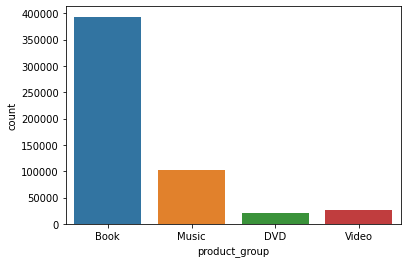

In [10]:
products_data, reviews_data = parse_data()
product_df = pd.DataFrame(products_data) 
sns.countplot(x='product_group',data=product_df)

# 1. Analysis based on user reviews

### (1) Reviews data preprocessing

In [11]:
reviews_data_dict = {}
for each_review in reviews_data:
    if each_review['customer_id'] not in reviews_data_dict:
        reviews_data_dict[each_review['customer_id']] = copy.deepcopy(each_review)

# 1. drop extra columns
all_reviews_info = []
for customer_id, reviews_info in reviews_data_dict.items():
    all_reviews_info.append({'userId': customer_id,
                             'productId': reviews_info['product_asin'],
                             'rating': reviews_info['rating']
                             })

df = pd.DataFrame(all_reviews_info)
# 2. drop duplicates
df.drop_duplicates(inplace=True)

### (2) View reviews distribution

In [12]:
print('reviews info:\n', df.head())
print("\nTotal numbers of ratings :",df.shape[0])
print("Total numbers of Users   :", len(np.unique(df.userId)))
print("Total numbers of products:", len(np.unique(df.productId)))

reviews info:
            userId   productId  rating
0  A2JW67OY8U6HHK  0827229534       5
1  A2VE83MZF98ITY  0827229534       5
2  A11NCO6YTE4BTJ  0738700797       5
3   A9CQ3PLRNIR83  0738700797       4
4  A13SG9ACZ9O5IM  0738700797       5

Total numbers of ratings : 1555170
Total numbers of Users   : 1555170
Total numbers of products: 268526


In [13]:
counts1 = df['userId'].value_counts()

Data_new = df[df['userId'].isin(counts1[counts1 >= 0].index)]
Data_new.head()

Data_new.groupby('productId')['rating'].mean().sort_values(ascending=False)

productId
0001474103    5.0
0785268847    5.0
0785268758    5.0
0785268715    5.0
0785268596    5.0
             ... 
B000008131    1.0
B00000IPRV    1.0
0439042437    1.0
0619063017    1.0
6302797500    1.0
Name: rating, Length: 268526, dtype: float64

C:\Users\Liam\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


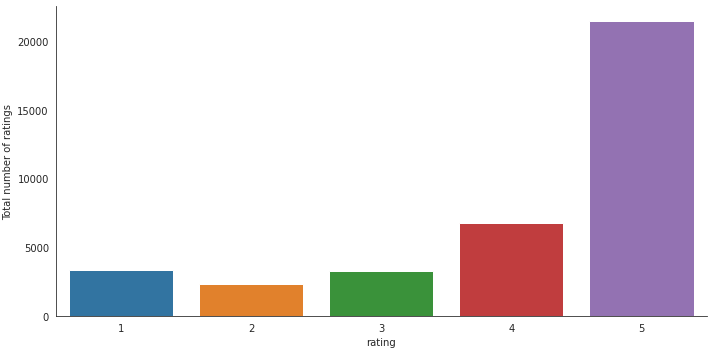

In [7]:
with sns.axes_style('white'):
    g = sns.catplot('rating', x=None, y=None, data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [8]:
#Calculate the density of the rating matrix
final_ratings_matrix = df.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings) * 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (37143, 2484)
given_num_of_ratings =  37143
possible_num_of_ratings =  92263212
density: 0.04%


In [9]:
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A1001URKW36W4Z,A100307XCCSKWR,A1008EEMWRT7DD,A1009EATDFMCM5,A100DMMBKT8HO5,A100QT7OUYSC7H,A100T19LDH0GGN,A100TW8FZECWD6,A100ZYQ4ENTZ57,A101C99CG8EFUH,...,AZY8BBBKOLBFG,AZY96LU53VWGO,AZYFIHUY6BCBQ,AZYFJ8OO3B1UH,AZYG4QMGSL4ZX,AZYM1KLRKD2GH,AZZ3RCXJW1SCO,AZZCXDP3D6IZK,AZZIZ963ACJSH,AZZU7B3NG6QRZ
productId,,,,,,,,,,,,,,,,,,,,,
0001474103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020160224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0027348407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028018281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0028612922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Count of user_id for each unique product as recommendation score
Data_new_grouped = df.groupby('productId').agg({'userId': 'count'}).reset_index()
Data_new_grouped.rename(columns = {'userId': 'score'},inplace=True)
Data_new_grouped.head()

,productId,score
0,0001474103,2
1,0020160224,9
2,0027348407,20
3,0028018281,3
4,0028612922,5


In [11]:
train_data_sort = Data_new_grouped.sort_values(['score', 'productId'], ascending = [0,1])
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
#Get the top 5 recommendations
popularity_recommendations = train_data_sort.head(5)
print('Top 5 recommendations:\n', popularity_recommendations)

Top 5 recommendations:
        productId  score  Rank
348   0385504209   2801   1.0
905   0792151712    989   2.0
1560  1590073991    884   3.0
441   0451191145    849   4.0
2339  B00005Q4JH    652   5.0


In [12]:
# Use popularity based recommender model to make predictions
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Add user_id column for which the recommendations are being generated
    user_recommendations.loc['userId'] = user_id

    #Bring user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [13]:
find_recom = [15,21,53]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %i)
    print(recommend(i))
    print("\n")

Here is the recommendation for the userId: 15

        Rank   productId  score
348      1.0  0385504209   2801
905      2.0  0792151712    989
1560     3.0  1590073991    884
441      4.0  0451191145    849
2339     5.0  B00005Q4JH    652
userId  15.0          15     15


Here is the recommendation for the userId: 21

        Rank   productId  score
348      1.0  0385504209   2801
905      2.0  0792151712    989
1560     3.0  1590073991    884
441      4.0  0451191145    849
2339     5.0  B00005Q4JH    652
userId  21.0          21     21


Here is the recommendation for the userId: 53

        Rank   productId  score
348      1.0  0385504209   2801
905      2.0  0792151712    989
1560     3.0  1590073991    884
441      4.0  0451191145    849
2339     5.0  B00005Q4JH    652
userId  53.0          53     53




C:\Users\Liam\AppData\Local\Temp\ipykernel_3548\1109149030.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations.loc['userId'] = user_id


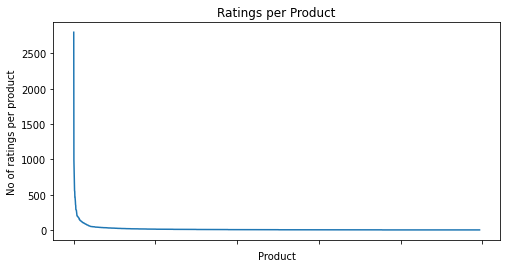

In [14]:
no_of_ratings_per_product = df.groupby(by='productId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('Ratings per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

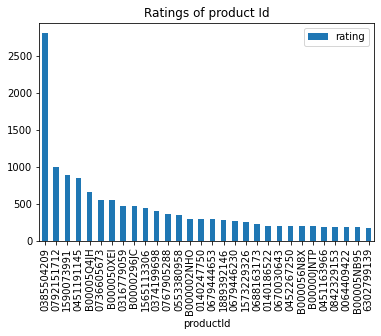

In [15]:
# Top 30 recommendations for the users

popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")
plt.title("Ratings of product Id")
plt.show()

# Using KNN to train

In [16]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from collections import defaultdict

### Reading the dataset

In [17]:
reader = Reader(rating_scale=(1, 5))
data1 = Dataset.load_from_df(Data_new, reader)

### Splitting the dataset

In [ ]:
train_dataset, test_dataset = train_test_split(data1, test_size=0.3,random_state=123)
print(test_dataset)

### Training the model

In [19]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(train_dataset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred = algo.test(test_dataset)
print(test_pred)

In [21]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(test_pred, n=5)
print(top_n)

In [23]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1VXS8VS3KFS7Q ['0805072845']
A1W0F14FN17CIP ['1590073991']
A2PMDGKYDMY5WG ['059514909X']
AWJIOBIC5QZZG ['0312983220']
A36RD32EKMJZ0O ['0871296152']
A1L1RM100N7JIP ['1590073991']
A2J6BOP8NKA3QL ['0374199698']
A1RLGLP70NMFYC ['0875421210']
A3BZAAGFN6MF99 ['0385504209']
A11C3ZDCLJYAYH ['0553380958']
A29NSI7MW43H5Y ['B0000262WI']
A3EOHYIHQM3KK ['B000002V0Q']
A2Q2O2FBPUPLNA ['B000002V0Q']
AJN8E9YK4DBIC ['067972186X']
A3VQGBQNNWU932 ['B000002NHU']
AFH6D5DT3AO7I ['0553479431']
AE8WOA8K849J0 ['B000050XEI']
A2FAZ87IRKLLOL ['0736605673']
APSUYPDZH178L ['B000056N8D']
AM1MV43V9ZRUA ['1889392146']
A2GP0K91AWQMO2 ['B00004RFIE']
A1BUZL7Z5Y2FTZ ['0385504209']
AU7O296O6PXZM ['0767905288']
A1HJDGM158VJ09 ['B000050XEI']
A1QA409K66V0CM ['0790733382']
A32SSFKVGKOK0O ['0375706429']
A2P3IZPG7ZJH6B ['1573229326']
A1P4EAD5BXZHS3 ['B00004TLSK']
A1N17TJUY0RZAN ['0312865325']
A2WDVFX0ZC0IVW ['1573229571']
A2P3V90FCAQ2LQ ['1590073991']
A11PX897HYBJB3 ['0316779059']
A1UQRTDHXFC657 ['0679446230']
A3IZTLBGT2X421 ['0

# Test the recommender system

In [24]:
uid = "A231WM2Z2JL0U3"  # raw user id (as in the ratings file). They are **strings**!
iid = "B00004RC2D"  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=0.0, verbose=True)
print(pred)

user: A231WM2Z2JL0U3 item: B00004RC2D r_ui = 0.00   est = 4.10   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: A231WM2Z2JL0U3 item: B00004RC2D r_ui = 0.00   est = 4.10   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


In [ ]:
item_dict = {}
for uid, value in top_n.items():
    asin, rating = value[0]
    if asin not in item_dict:
        item_dict[asin] = [uid]
    else:
        item_dict[asin].append(uid)
print(item_dict)

In [26]:
prediction = pd.DataFrame(test_pred)
print(prediction)

                  uid         iid  r_ui       est  \
0      A1VXS8VS3KFS7Q  0805072845   3.0  4.099192   
1      A1W0F14FN17CIP  1590073991   3.0  4.099192   
2      A2PMDGKYDMY5WG  059514909X   5.0  4.099192   
3       AWJIOBIC5QZZG  0312983220   5.0  4.099192   
4      A36RD32EKMJZ0O  0871296152   5.0  4.099192   
...               ...         ...   ...       ...   
11138   AU3ZATGE0KGTS  1874416125   5.0  4.099192   
11139  A3DWUSQ2CZ0Y2U  0613505735   5.0  4.099192   
11140  A2NKHA2EFY8QXV  0553298046   5.0  4.099192   
11141  A1ILBKPRXHOO8P  0451191145   2.0  4.099192   
11142  A3H7AOFQDPU0JV  0064409422   5.0  4.099192   

                                                 details  
0      {'was_impossible': True, 'reason': 'User and/o...  
1      {'was_impossible': True, 'reason': 'User and/o...  
2      {'was_impossible': True, 'reason': 'User and/o...  
3      {'was_impossible': True, 'reason': 'User and/o...  
4      {'was_impossible': True, 'reason': 'User and/o...  
...      

# Test performance of the recommender system

In [27]:
accuracy.rmse(test_pred, verbose=True)
accuracy.mae(test_pred, verbose=True)

RMSE: 1.3094
MAE:  1.0447


1.044718488323128